## Connect Four and Chess Reinforcement Learning Tutorial

Reinforcement learning is a machine learning paradigm where an agent learns to make decisions by interacting with an environment. The agent aims to maximize a cumulative reward signal received from the environment over time. It learns through trial and error, adjusting its actions based on the feedback it receives. One key concept in reinforcement learning is the notion of an action-value function, which estimates the expected return of taking a particular action in a given state. The agent's goal is to learn the optimal policy, a strategy that dictates which action to take in each state to maximize long-term rewards. Neural networks, on the other hand, are computational models inspired by the structure and function of the human brain's neural networks. They consist of interconnected nodes organized in layers, with each node performing a simple computation. Neural networks excel at learning complex patterns and relationships in data, making them well-suited for tasks like function approximation and classification. In reinforcement learning, neural networks are often used to approximate the action-value function or the policy. By training neural networks with reinforcement learning algorithms, agents can learn to make decisions in complex environments, achieving human-level or superhuman performance in various tasks. Through the synergy of reinforcement learning and neural networks, we can tackle challenging problems in fields like robotics, gaming, finance, and healthcare, driving advancements in artificial intelligence research and applications.

In [ ]:
!pip install gym
!pip install tensorflow
!pip install mnist_env


In [ ]:
!pip install kaggle_environments

Connect Four and chess serve as illustrative examples to explain fundamental concepts in game theory, strategy, and decision-making. Connect Four, a popular board game, involves dropping colored discs into a vertical grid with the goal of forming a line of four discs of the same color either vertically, horizontally, or diagonally. This game represents a simple yet rich environment for exploring strategies such as blocking opponents' moves and creating opportunities for future victories. Similarly, 4x4 chess, a simplified version of traditional chess played on a smaller board, offers insights into tactical maneuvers, piece coordination, and positional advantages. Both games demonstrate how players must analyze the current state of the board, anticipate opponents' moves, and formulate long-term strategies to achieve success. By studying these games, individuals can develop critical thinking skills, pattern recognition abilities, and an understanding of decision-making under uncertainty. Moreover, these games serve as valuable testbeds for exploring and developing artificial intelligence algorithms, including reinforcement learning and neural networks, to create intelligent agents capable of competing with or surpassing human-level performance in strategic board games. Through the lens of Connect Four and 4x4 chess, we gain valuable insights into the complexities of decision-making, strategy formulation, and the interplay between human cognition and computational intelligence.

In [30]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2,
                                            shape=(1,self.rows,self.columns), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _


In [31]:
# Create ConnectFour environment
env = ConnectFourGym(agent2="random")

In [32]:
import torch as th
import torch.nn as nn

!pip install "stable-baselines3"
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# Neural network for predicting action values
class CustomCNN(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # CxHxW images (channels first)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
)

# Initialize agent
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0)




In [12]:
# Train agent
model.learn(total_timesteps=60000)

In [33]:
def agent1(obs, config):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(1, 6,7))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move.
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [34]:
# Create the game environment
env = make("connectx")

# Two random agents play one game round
env.run([agent1, "random"])

# Show the game
env.render(mode="ipython")

In [15]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [18]:
get_win_percentages(agent1=agent1, agent2="random")

Agent 1 Win Percentage: 0.76
Agent 2 Win Percentage: 0.24
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


Code from Alexis Cook. Super cool example: https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning

Now Chess...4 x 4

In [35]:
import gym
from gym import spaces
import numpy as np

class SimpleChessEnv(gym.Env):
    def __init__(self):
        self.board_size = 4  # Simplified chessboard size
        self.action_space = spaces.Discrete(64)  # Total number of possible actions
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.board_size, self.board_size), dtype=np.float32)
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int8)
        self.player_turn = 1  # Player 1 starts the game

    def reset(self):
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int8)
        self.player_turn = 1
        return self.board

    def step(self, action):
        row, col = action // self.board_size, action % self.board_size
        if self.board[row, col] != 0:
            return self.board, -1, False, {}  # Invalid move, penalize the agent

        self.board[row, col] = self.player_turn
        reward = self.calculate_reward()
        done = self.is_game_over()
        self.player_turn = -1 if self.player_turn == 1 else 1  # Switch player turn
        return self.board, reward, done, {}

    def calculate_reward(self):
        # Reward logic based on game outcome (e.g., checkmate, stalemate, etc.)
        # For simplicity, we just return 1 for a win, 0 for a draw, and -1 for a loss
        # You can implement more sophisticated reward logic here
        if self.is_winner():
            return 1
        elif self.is_draw():
            return 0
        else:
            return 0

    def is_game_over(self):
        # Check if the game is over (e.g., checkmate or stalemate)
        return self.is_winner() or self.is_draw()

    def is_winner(self):
        # Check if any player has won the game
        # Implement the winning condition here
        return False  # Placeholder, implement your logic

    def is_draw(self):
        # Check if the game is a draw
        # Implement the draw condition here
        return False  # Placeholder, implement your logic

    def render(self, mode='human'):
        # Display the current state of the chessboard
        print(self.board)


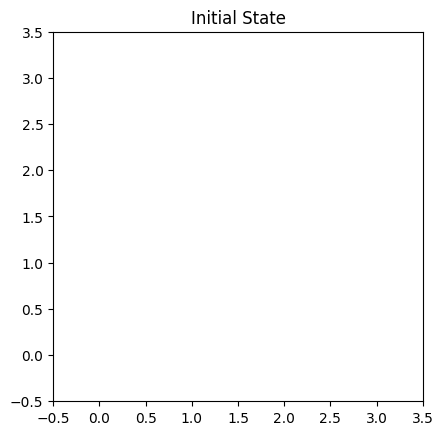

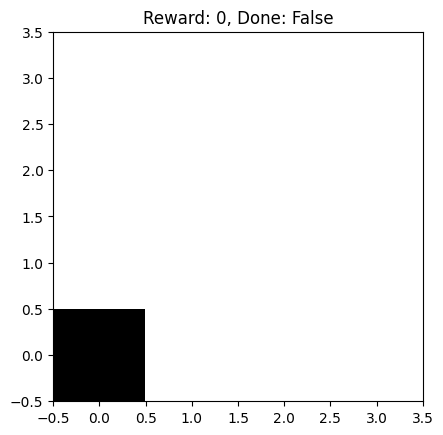

In [40]:
import gym
import matplotlib.pyplot as plt

# Create the environment
env = SimpleChessEnv()

# Reset the environment
obs = env.reset()

# Visualize the initial state
plt.imshow(obs, cmap='binary', origin='lower')
plt.title("Initial State")
plt.show()

# Perform some random actions and visualize the environment
for _ in range(5):
    action = env.action_space.sample()  # Random action
    row, col = action // env.board_size, action % env.board_size
    if row >= env.board_size or col >= env.board_size or env.board[row, col] != 0:
        continue  # Skip invalid action
    obs, reward, done, _ = env.step(action)
    plt.imshow(obs, cmap='binary', origin='lower')
    plt.title(f"Reward: {reward}, Done: {done}")
    plt.show()
    if done:
        break






In [ ]:
import random
import numpy as np

In [41]:
# Calculates score if agent drops piece in selected column
def score_move(grid, col, mark, config):
    next_grid = drop_piece(grid, col, mark, config)
    score = get_heuristic(next_grid, mark, config)
    return score

# Helper function for score_move: gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

# Helper function for score_move: calculates value of heuristic for grid
def get_heuristic(grid, mark, config):
    num_threes = count_windows(grid, 3, mark, config)
    num_fours = count_windows(grid, 4, mark, config)
    num_threes_opp = count_windows(grid, 3, mark%2+1, config)
    score = num_threes - 1e2*num_threes_opp + 1e6*num_fours
    return score

# Helper function for get_heuristic: checks if window satisfies heuristic conditions
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

In [42]:
# The agent is always implemented as a Python function that accepts two arguments: obs and config
def agent(obs, config):
    # Get list of valid moves (columns where the top row is empty)
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]

    # Convert the board to a 2D grid (reshape the flat board into a 2D grid)
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)

    # Use the heuristic to assign a score to each possible move in the next turn
    # Here, the score_move function evaluates each possible move and assigns a score
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config) for col in valid_moves]))

    # Get a list of columns (moves) that maximize the heuristic score
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]

    # Select at random from the maximizing columns (randomly select one move among the best moves)
    return random.choice(max_cols)


In [43]:
from kaggle_environments import make, evaluate

# Create the game environment
env = make("connectx")

# Two random agents play one game round
env.run([agent, "random"])

# Show the game
env.render(mode="ipython")

In [44]:
get_win_percentages(agent1=agent, agent2="random")

Agent 1 Win Percentage: 0.99
Agent 2 Win Percentage: 0.01
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
